# Part II (Vatic)

In [1]:
from vatic.engines import Simulator
from vatic.data.loaders import load_input, RtsLoader
from vatic.engines import Simulator

import pandas as pd
import numpy as np

from pathlib import Path
import dill as pickle
import os
from datetime import datetime
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
import datetime
import pickle

In [3]:
grid_name = "Texas-7k"
RUC_MIPGAPS = {grid_name: 0.01}
SCED_HORIZONS = {grid_name: 4}
grid = grid_name  #For Texas, put 'Texas-7k' or 'Texas-7k_2030'
num_days = 1  
init_state_file = None 

In [4]:
def get_input_for_simulation(date):
    start_date = date #For Texas pick a date in 2018
    template, gen_data, load_data = load_input(grid, start_date, num_days=num_days, init_state_file=init_state_file)
    return template, gen_data, load_data, start_date
    
def get_actual_energy_columns(df, etype):
    output = []
    for col in df.columns:
        if(etype in col[1] and col[0] == "actl"):
            output.append(col)
    return output

def get_p_value(df):
    solar_cols = get_actual_energy_columns(df, 'Solar')
    wind_cols = get_actual_energy_columns(df, 'Wind')
    solar_sum = sum(df[solar_cols].sum(axis=1))
    wind_sum = sum(df[wind_cols].sum(axis=1))
    print(solar_sum, wind_sum)
    p = (solar_sum * 0.75) / wind_sum
    return p
    
def change_generation_data(gen_data, scenario):
    if(scenario == 2): # cloudy day
        solar_cols = get_actual_energy_columns(gen_data, "Solar")
        gen_data[solar_cols] *= 0.25
    elif(scenario == 3): # wind equivalend
        wind_cols = get_actual_energy_columns(gen_data, "Wind")
        p = get_p_value(gen_data)
        print("p value", p)
        gen_data[wind_cols] *= (1-p)
    return gen_data

def convert_lbs_to_metric_tons(x):
    '''
    Converts a value in lbs to metric tons
    '''
    return x/2204.6223

def change_load_data(load_data):
    '''
    Increases the demand (through load_data) between 10:00 to 18:00 hours by 40%
    Args:
        load_data (pd.DataFrame): load data
    Returns:
        modified load data (pd.DataFrame)
    '''
    load_data_input = load_data.copy()
    v = load_data_input.index
    # Filtering on the July date
    v2 = v[v.date == pd.to_datetime("2018-07-19").date()]
    # Filtering on the times to be updated
    v3 = v2[(v2.time >= datetime.time(10)) & (v2.time <= datetime.time(18))]
    load_data_input.loc[v3, "actl"] = 1.4 * load_data_input.loc[v3, "actl"].values
    return load_data_input

In [5]:
CO2_data = pd.read_csv("emissions_CO2.csv")
dates = ["2018-01-19", "2018-07-19"]
scenario_index_to_name = {1: "baseline", 2: "cloudy", 3: "wind_equivalent"}

### Baseline Simulation

In [7]:
siml = Simulator(template, gen_data, load_data, None,
                pd.to_datetime(start_date).date(), 1, solver='gurobi',
                solver_options={}, run_lmps=False, mipgap=RUC_MIPGAPS[grid],
                load_shed_penalty = 1e4, reserve_shortfall_penalty = 1e3,
                reserve_factor=0.05, output_detail=3,
                prescient_sced_forecasts=True, ruc_prescience_hour=0,
                ruc_execution_hour=16, ruc_every_hours=24,
                ruc_horizon=48, sced_horizon=SCED_HORIZONS[grid],
                lmp_shortfall_costs=False,
                enforce_sced_shutdown_ramprate=False,
                no_startup_shutdown_curves=False,
                init_ruc_file=None, verbosity=0,
                output_max_decimals=4, create_plots=False,
                renew_costs=None, save_to_csv=False, 
                last_conditions_file=None,)
report_dfs = siml.simulate()

(ordered) position is deprecated.  Please use at()  (deprecated in 6.1, will
be removed in (or after) 7.0) (called from /home/pl7830/.conda/envs/vatic-
test/lib/python3.11/site-packages/vatic/models/params.py:1022)
(ordered) position is deprecated.  Please use at()  (deprecated in 6.1, will
be removed in (or after) 7.0) (called from /home/pl7830/.conda/envs/vatic-
test/lib/python3.11/site-
packages/egret/model_library/unit_commitment/startup_costs.py:126)
(ordered) position is deprecated.  Please use at()  (deprecated in 6.1, will
be removed in (or after) 7.0) (called from /home/pl7830/.conda/envs/vatic-
test/lib/python3.11/site-
packages/egret/model_library/unit_commitment/startup_costs.py:127)
(ordered) position is deprecated.  Please use at()  (deprecated in 6.1, will
be removed in (or after) 7.0) (called from /home/pl7830/.conda/envs/vatic-
test/lib/python3.11/site-
packages/egret/model_library/unit_commitment/startup_costs.py:130)
Calculating PTDF Matrix Factorization
ignored.  (d

In [8]:
with open("report_dfs.pkl", "wb") as f:
    pickle.dump(report_dfs, f)

In [39]:
thermal_detail = report_dfs["thermal_detail"].reset_index()
thermal_detail_co2 = pd.merge(thermal_detail, co2_data, left_on = "Generator", right_on = "GEN UID", how = "inner")
# Dispatch assumed to be in MWh
thermal_detail_co2["CO2_Total"] = thermal_detail_co2["Dispatch"]*thermal_detail_co2["CO2 Emissions Lbs/MWh"]
thermal_detail_co2["CO2_Total"].sum()

np.float64(1063377974.6755733)

### Matching solar loss with equivalent wind loss

In [5]:
for date in dates:
    template, gen_data, load_data, start_date = get_input_for_simulation(date)
    for scenario in [1, 2, 3]:
        gen_data_modified = change_generation_data(gen_data, scenario)
        scenario_name = scenario_index_to_name[scenario]
        print(date, scenario_name, "Started!")
        siml = Simulator(template, gen_data_modified, load_data, None,
                    pd.to_datetime(start_date).date(), 1, solver='gurobi',
                    solver_options={}, run_lmps=False, mipgap=RUC_MIPGAPS[grid],
                    load_shed_penalty = 1e4, reserve_shortfall_penalty = 1e3,
                    reserve_factor=0.05, output_detail=3,
                    prescient_sced_forecasts=True, ruc_prescience_hour=0,
                    ruc_execution_hour=16, ruc_every_hours=24,
                    ruc_horizon=48, sced_horizon=SCED_HORIZONS[grid],
                    lmp_shortfall_costs=False,
                    enforce_sced_shutdown_ramprate=False,
                    no_startup_shutdown_curves=False,
                    init_ruc_file=None, verbosity=0,
                    output_max_decimals=4, create_plots=False,
                    renew_costs=None, save_to_csv=False, 
                    last_conditions_file=None,)
        # Computation
        report_dfs = siml.simulate()
        with open(f"report_dfs_{date}_{scenario_name}.pkl", "wb") as f:
            pickle.dump(report_dfs, f)
        print(date, scenario_name, "Finished!")
        print("")

31324.076762651617 505316.56833711837
p value 0.04649176188562154
2018-01-19 wind_equivalent Started!
(ordered) position is deprecated.  Please use at()  (deprecated in 6.1, will
be removed in (or after) 7.0) (called from /home/pl7830/.conda/envs/vatic-
test/lib/python3.11/site-packages/vatic/models/params.py:1022)
(ordered) position is deprecated.  Please use at()  (deprecated in 6.1, will
be removed in (or after) 7.0) (called from /home/pl7830/.conda/envs/vatic-
test/lib/python3.11/site-
packages/egret/model_library/unit_commitment/startup_costs.py:126)
(ordered) position is deprecated.  Please use at()  (deprecated in 6.1, will
be removed in (or after) 7.0) (called from /home/pl7830/.conda/envs/vatic-
test/lib/python3.11/site-
packages/egret/model_library/unit_commitment/startup_costs.py:127)
(ordered) position is deprecated.  Please use at()  (deprecated in 6.1, will
be removed in (or after) 7.0) (called from /home/pl7830/.conda/envs/vatic-
test/lib/python3.11/site-
packages/egret/

In [5]:
# Computing CO2 Emissions
CO2_df = pd.DataFrame(columns = ["date", "scenario_name", "CO2 Emissions (in MT)"])
row = 0
for date in dates:
    for scenario in [1, 2, 3]:
        scenario_name = scenario_index_to_name[scenario]
        # Fetching the stored pickle files
        with open(f"report_dfs_{date}_{scenario_name}.pkl", "rb") as f:
            report_dfs = pickle.load(f)
        # Extracting thermal details
        thermal_detail = report_dfs["thermal_detail"].reset_index()
        thermal_detail_CO2 = pd.merge(thermal_detail, CO2_data, left_on = "Generator", right_on = "GEN UID", how = "inner")
        # Dispatch assumed to be in MWh
        thermal_detail_CO2["CO2_Total"] = thermal_detail_CO2["Dispatch"]*thermal_detail_CO2["CO2 Emissions Lbs/MWh"]
        CO2_total = thermal_detail_CO2["CO2_Total"].sum()
        CO2_total = convert_lbs_to_metric_tons(CO2_total)
        print(date, scenario_name, CO2_total)
        CO2_df.loc[row] = [date, scenario_name, CO2_total]
        row += 1
        print("")

2018-01-19 baseline 482340.20615484717

2018-01-19 cloudy 486732.5932620959

2018-01-19 wind_equivalent 487034.04493126826

2018-07-19 baseline 677450.4814349589

2018-07-19 cloudy 684518.494041032

2018-07-19 wind_equivalent 686277.0734749862



In [6]:
# temp = CO2_df.set_index(["date", "scenario_name"])
CO2_df["base_emissions"] = 0
for date in dates:
    val = CO2_df[(CO2_df["date"] == date) & (CO2_df["scenario_name"] == "baseline")]["CO2 Emissions (in MT)"].iloc[0]
    CO2_df.loc[CO2_df["date"] == date, "base_emissions"] = val
CO2_df["pct_change"] = (CO2_df["CO2 Emissions (in MT)"] - CO2_df["base_emissions"])*100/CO2_df["base_emissions"]
CO2_df

,date,scenario_name,CO2 Emissions (in MT),base_emissions,pct_change
0,2018-01-19,baseline,482340.206155,482340.206155,0.000000
1,2018-01-19,cloudy,486732.593262,482340.206155,0.910641
2,2018-01-19,wind_equivalent,487034.044931,482340.206155,0.973139
3,2018-07-19,baseline,677450.481435,677450.481435,0.000000
4,2018-07-19,cloudy,684518.494041,677450.481435,1.043325
5,2018-07-19,wind_equivalent,686277.073475,677450.481435,1.302913


#### As seen, CO2 emissions increase in both cases when the solar or the wind generation is curtailed. Further, the increase is more in case of wind curtailment (0.97% vs 0.91%, 1.30% vs 1.04%) as compared to solar curtailment, indicating that wind saves a lot of CO2 from being emitted while fulfilling the demand! (Note that generation was only changed on the actual columns.)

### Summer Daytime Demand Shock

In [48]:
date = "2018-07-19"
template, gen_data, load_data, start_date = get_input_for_simulation(date)
load_data_modified = change_load_data(load_data)
siml = Simulator(template, gen_data, load_data_modified, None,
            pd.to_datetime(start_date).date(), 1, solver='gurobi',
            solver_options={}, run_lmps=False, mipgap=RUC_MIPGAPS[grid],
            load_shed_penalty = 1e4, reserve_shortfall_penalty = 1e3,
            reserve_factor=0.05, output_detail=3,
            prescient_sced_forecasts=True, ruc_prescience_hour=0,
            ruc_execution_hour=16, ruc_every_hours=24,
            ruc_horizon=48, sced_horizon=SCED_HORIZONS[grid],
            lmp_shortfall_costs=False,
            enforce_sced_shutdown_ramprate=False,
            no_startup_shutdown_curves=False,
            init_ruc_file=None, verbosity=0,
            output_max_decimals=4, create_plots=False,
            renew_costs=None, save_to_csv=False, 
            last_conditions_file=None,)
report_dfs = siml.simulate()

# Storing output
with open(f"report_dfs_{date}_demand_shock.pkl", "wb") as f:
    pickle.dump(report_dfs, f)

(ordered) position is deprecated.  Please use at()  (deprecated in 6.1, will
be removed in (or after) 7.0) (called from /home/pl7830/.conda/envs/vatic-
test/lib/python3.11/site-packages/vatic/models/params.py:1022)
(ordered) position is deprecated.  Please use at()  (deprecated in 6.1, will
be removed in (or after) 7.0) (called from /home/pl7830/.conda/envs/vatic-
test/lib/python3.11/site-
packages/egret/model_library/unit_commitment/startup_costs.py:126)
(ordered) position is deprecated.  Please use at()  (deprecated in 6.1, will
be removed in (or after) 7.0) (called from /home/pl7830/.conda/envs/vatic-
test/lib/python3.11/site-
packages/egret/model_library/unit_commitment/startup_costs.py:127)
(ordered) position is deprecated.  Please use at()  (deprecated in 6.1, will
be removed in (or after) 7.0) (called from /home/pl7830/.conda/envs/vatic-
test/lib/python3.11/site-
packages/egret/model_library/unit_commitment/startup_costs.py:130)
Calculating PTDF Matrix Factorization
ignored.  (d

ValueError: Invalid parameter value: ReserveRequirement[4] = 'nan', value type=<class 'float'>.
	Value not in parameter domain NonNegativeReals

In [6]:
def get_total_CO2_emitted(report_dfs):
    '''
    Computes the total CO2 emitted during the entire day (using thermal detail dataframe in report dfs and CO2 emissions data for each generator)
    Args:
        report_dfs (dict[str, pd.DataFrame]: the master data object
    Returns:
        the total CO2 emitted (float)
    '''
    # Extracting thermal details
    thermal_detail = report_dfs["thermal_detail"].reset_index()
    thermal_detail_CO2 = pd.merge(thermal_detail, CO2_data, left_on = "Generator", right_on = "GEN UID", how = "inner")
    # Dispatch assumed to be in MWh
    thermal_detail_CO2["CO2_Total"] = thermal_detail_CO2["Dispatch"]*thermal_detail_CO2["CO2 Emissions Lbs/MWh"]
    CO2_total = thermal_detail_CO2["CO2_Total"].sum()
    CO2_total = convert_lbs_to_metric_tons(CO2_total)
    return CO2_total

In [23]:
with open(f"report_dfs_{date}_demand_shock.pkl", "rb") as f:
    report_dfs_ds = pickle.load(f)

with open(f"report_dfs_{date}_baseline.pkl", "rb") as f:
    report_dfs_bl = pickle.load(f)

#### CO2 Emission Analysis

In [24]:
co2_baseline = get_total_CO2_emitted(report_dfs_bl)
co2_shock = get_total_CO2_emitted(report_dfs_ds)
print("CO2 Emission during demand shock:", co2_shock)
print("CO2 Emission during baseline:", co2_baseline)

CO2 Emission during demand shock: 719156.190608769
CO2 Emission during baseline: 677450.4814349589


#### Total Thermal Dispatch, by Technology

In [45]:
print("Under Demand Shock:")
data_ds = report_dfs_ds["thermal_detail"].copy()
data_ds["Tech"] = data_ds.reset_index()["Generator"].str.split("_").transform(lambda x: x[1]).values
data_ds.groupby("Tech")["Dispatch"].sum().sort_values(ascending = False).round(2)

Under Demand Shock:


Tech
NaturalGasFiredCombinedCycle          623610.25
ConventionalSteamCoal                 284203.92
NaturalGasSteamTurbine                152954.22
Nuclear                               111339.38
NaturalGasFiredCombustionTurbine       65581.39
NaturalGasInternalCombustionEngine      3525.32
OtherGases                              3221.43
AllOther                                1871.23
Wood/WoodWasteBiomass                   1287.45
Name: Dispatch, dtype: float64

In [46]:
print("For Baseline:")
data_bl = report_dfs_bl["thermal_detail"].copy()
data_bl["Tech"] = data_bl.reset_index()["Generator"].str.split("_").transform(lambda x: x[1]).values
data_bl.groupby("Tech")["Dispatch"].sum().sort_values(ascending = False).round(2)

For Baseline:


Tech
NaturalGasFiredCombinedCycle          619197.45
ConventionalSteamCoal                 265605.25
NaturalGasSteamTurbine                124505.32
Nuclear                               106637.38
NaturalGasFiredCombustionTurbine       61762.96
NaturalGasInternalCombustionEngine      3395.75
OtherGases                              3221.43
AllOther                                1778.14
Wood/WoodWasteBiomass                   1249.96
Name: Dispatch, dtype: float64

#### Headroom Analysis, by Tech

In [47]:
print("Under Demand Shock:")
data_ds.groupby("Tech")["Headroom"].sum().sort_values(ascending = False).round(2)

Under Demand Shock:


Tech
NaturalGasFiredCombinedCycle          41944.03
NaturalGasSteamTurbine                24872.46
ConventionalSteamCoal                  3947.69
NaturalGasFiredCombustionTurbine       3218.16
AllOther                                185.02
NaturalGasInternalCombustionEngine      183.52
Wood/WoodWasteBiomass                   175.98
OtherGases                               -0.00
Nuclear                                  -0.00
Name: Headroom, dtype: float64

In [48]:
print("For Baseline:")
data_bl.groupby("Tech")["Headroom"].sum().sort_values(ascending = False).round(2)

For Baseline:


Tech
NaturalGasFiredCombinedCycle          43836.01
NaturalGasSteamTurbine                39132.30
ConventionalSteamCoal                 11278.96
NaturalGasFiredCombustionTurbine       6059.70
Nuclear                                2625.64
NaturalGasInternalCombustionEngine      306.84
AllOther                                245.89
Wood/WoodWasteBiomass                   213.47
OtherGases                               -0.00
Name: Headroom, dtype: float64

#### Observations
- Dispatch is increasing under the demand shock (which is expected since the higher the demand, the more dispatch that has to take place); Also note that dispatch increased across all tech (except OtherGases)
- As expected, the headroom decreased under the demand shock since a part of the original headroom had to be used to fulfil the demand shock!
- Nuclear has a lot of headroom in baseline scenario but falls during the demand shock!
- The relative order of the technologies, (ordered by their dispatch or their headroom) remains more or less the same irrespective of whether the scenario is a baseline or that of a demand shock!

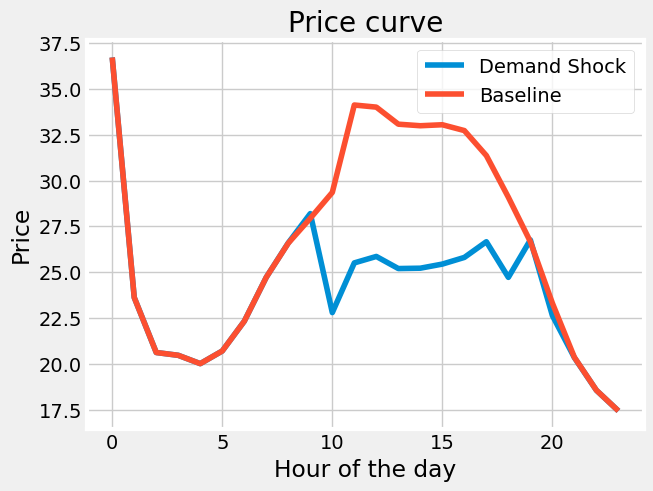

In [56]:
# Understanding price output
import matplotlib.pyplot as plt
plt.plot(report_dfs_ds['hourly_summary']['Price'].values, label = "Demand Shock")
plt.plot(report_dfs_bl['hourly_summary']['Price'].values, label = "Baseline")
plt.legend()
plt.xlabel("Hour of the day")
plt.ylabel("Price")
plt.title("Price curve")
plt.show()